In [ ]:
# 
import numpy as np
import pandas as pd
from tqdm import tqdm 
import warnings

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# modeling imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE # !pip install -U imbalanced-learn

# evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# database connection
import sqlalchemy as db
ip = '34.132.168.244'
port = '5432'
db_name = 'EDAdb'
username = 'MrDmitry'
password = 'Bonus'
conn = db.create_engine(f"postgresql://{username}:{password}@{ip}:{port}/{db_name}") # online db

# 1. Data
## 1.1. Data Info
TODO

## 1.2. Loading Data

**Read .csv** from local machine

In [ ]:
df = pd.read_csv("fetal_health.csv")
df['fetal_health'] = df['fetal_health'].replace({1: 'Normal', 2: 'Suspect', 3: 'Pathological'})
df

**Write to Database** so that we can read from remote database every time we need to run this code

In [ ]:
# TODO
# df.to_sql(name='fetal_health', con=conn, index=False)

**Read from Database** directly without needing to provide local dataset

In [4]:
# TODO
# df = pd.read_sql('select * from fetal_health', conn)

**Split** to X and y

In [5]:
# X, y = df.drop("fetal_health", axis=1), df["fetal_health"]

# 2. EDA

**Classes Distribution** will allow us to get more understanding about our target classes (e.g. how many classes are there, how many row for each class) 

C:\Users\alsah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


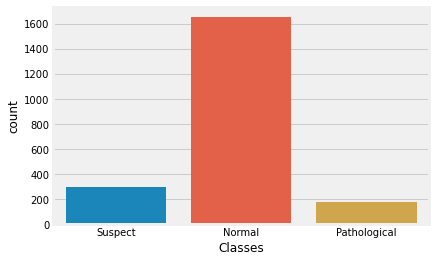

In [6]:
# classes distribution
sns.countplot(df["fetal_health"]).set(xlabel='Classes');

**Oversampling** using **SMOTE** to fix imbalance data

In [7]:
# transform the dataset
X, y = SMOTE().fit_resample(df.drop("fetal_health", axis=1), df["fetal_health"])
X['fetal_health'] = y
df = X.copy()

C:\Users\alsah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


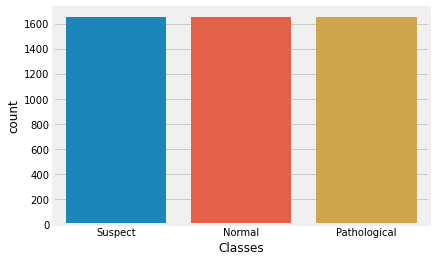

In [8]:
# classes distribution
sns.countplot(df["fetal_health"]).set(xlabel='Classes');

**Pairplot** shows the relationship between each feature and the others with respect to the target, also provide information about how likely each feature can distinguish target classes apart from from each other

In [9]:
# pairplot
# sns.pairplot(df, hue='fetal_health');

**Missing values & duplicates** any missing values must be filled or dropped and any duplicate rows has no meaning in our analysis

In [10]:
# misssing values and duplicates
print(f'Number of missing values is {df.isna().sum().sum()}\nNumber of duplicated rows is {df.duplicated().sum()}')

Number of missing values is 0
Number of duplicated rows is 23


In [11]:
# removing duplicates
df.drop_duplicates(inplace=True)

**Normalization** Why do we use normalization? 
<ol>
  <li>Plot outliers togther in one chart.</li>
  <li>Some algorithms are sensitive to the scale of the features (e.g. kNN, k-means and SVM) in the other hand some algorithems are NOT (e.g. tree-based algorithms). <a href='https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/'>source</a></li>
</ol>

In [21]:
# normalized_df=(df-df.mean())/df.std()
XX = df.drop('fetal_health', axis=1)
yy = df['fetal_health']
df_normalized=(XX-XX.min())/(XX.max()-XX.min())
df_normalized['fetal_health'] = yy
df = df_normalized.copy()
df

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,0.259259,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.813333,0.044118,0.472527,...,0.110092,0.034483,0.111111,0.000000,0.472441,0.587156,0.403670,0.271375,1.000000,Suspect
1,0.481481,0.315789,0.000000,0.400000,0.200000,0.0,0.0,0.066667,0.279412,0.000000,...,0.165138,0.655172,0.333333,0.100000,0.637795,0.577982,0.577982,0.044610,0.500000,Normal
2,0.500000,0.157895,0.000000,0.533333,0.200000,0.0,0.0,0.053333,0.279412,0.000000,...,0.165138,0.655172,0.277778,0.100000,0.637795,0.568807,0.559633,0.048327,0.500000,Normal
3,0.518519,0.157895,0.000000,0.533333,0.200000,0.0,0.0,0.053333,0.323529,0.000000,...,0.027523,0.413793,0.611111,0.000000,0.606299,0.559633,0.550459,0.048327,1.000000,Normal
4,0.481481,0.368421,0.000000,0.533333,0.000000,0.0,0.0,0.053333,0.323529,0.000000,...,0.027523,0.413793,0.500000,0.000000,0.606299,0.577982,0.559633,0.040892,1.000000,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,0.821229,0.000000,0.000865,0.062705,0.082512,0.0,0.0,0.690957,0.241262,0.103472,...,0.059407,0.555310,0.134219,0.005942,0.704918,0.682622,0.673448,0.033899,0.970290,Suspect
4961,0.454188,0.000000,0.001763,0.033914,0.000000,0.0,0.0,0.710956,0.031905,0.035022,...,0.658995,0.181185,0.009421,0.000000,0.580281,0.553730,0.527763,0.003717,0.584785,Suspect
4962,0.351852,0.000000,0.010395,0.066667,0.000000,0.0,0.0,0.728042,0.014706,0.578405,...,0.585408,0.074029,0.033509,0.000000,0.511811,0.467890,0.449541,0.000000,0.801585,Suspect
4963,0.787896,0.000000,0.000000,0.109280,0.000000,0.0,0.0,0.673883,0.033429,0.216778,...,0.852407,0.356604,0.070733,0.000000,0.755175,0.757306,0.736451,0.005749,0.863399,Suspect


#### Outliers

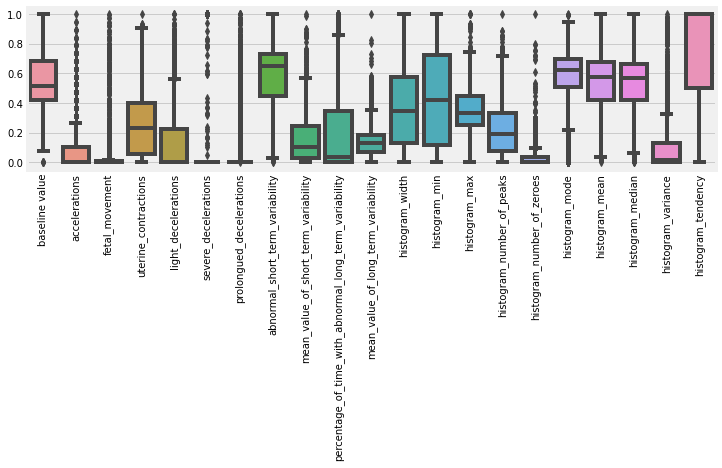

In [22]:
plt.figure(figsize=(11, 3))
sns.boxplot(data=df);
plt.xticks(rotation=90);

**Spliting Dataset**

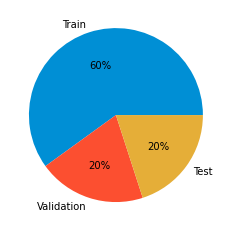

In [23]:
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

# create plot
plt.pie([X_train.shape[0], X_val.shape[0], X_test.shape[0]], 
        labels = ['Train', 'Validation', 'Test'], 
        autopct='%.0f%%')
plt.show()

## 3. Features Selection

In [24]:
# this function is used to evaluate different methods
from sklearn.metrics import precision_recall_fscore_support
def evaluation(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', labels=np.unique(y_pred))[0:3]

**Method 1** using Scikit Learn **SelectKBest** function

In [25]:
# from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# best featuers
pd.DataFrame({'F':f_classif(X, y)[0], 'names':X.columns}).sort_values('F', ascending=False)

,F,names
17,1907.830845,histogram_mean
18,1819.470361,histogram_median
16,1615.484548,histogram_mode
6,1413.624440,prolongued_decelerations
7,1359.904896,abnormal_short_term_variability
1,1249.804238,accelerations
0,749.150919,baseline value
10,744.120982,mean_value_of_long_term_variability
19,641.136046,histogram_variance
8,583.439661,mean_value_of_short_term_variability


In [26]:
def plot_results(model, li_score, li_precision, li_recall, li_fscore):
    plt.style.use('default')
    plt.figure(figsize=(11, 3))
    ax = sns.lineplot(data=pd.DataFrame({'r2 score':li_score,
                                    'precision':li_precision,
                                    'recall':li_recall,
                                    'fscore':li_fscore}))
    ax.set(xlabel='best k features', ylabel='evaluation values', 
           xticks=range(21), yticks=range(0, 101, 10), title=model)
    ax.grid()
    plt.show();

In [27]:
# Selecting k best featuers
def select_best(X, y, k):
    selector = SelectKBest(k=k)
    selector.fit_transform(X, y)
    cols = selector.get_support(indices=True)
    X_new = X.iloc[:,cols]
    return X_new

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.27it/s]


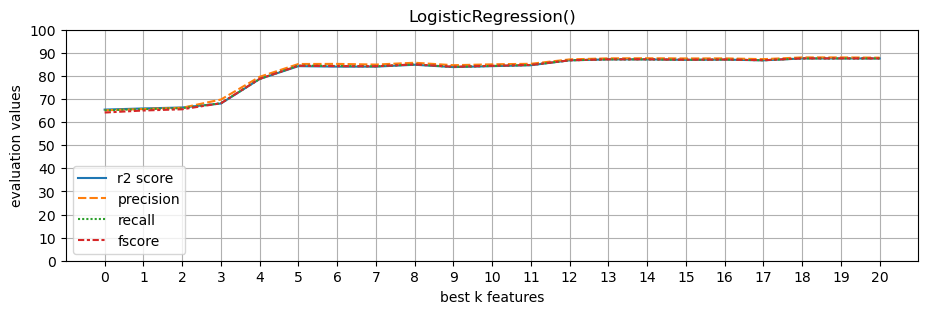

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.17it/s]


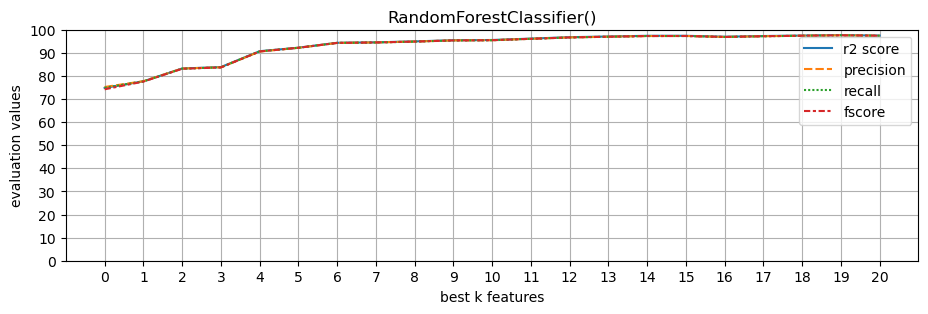

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.33it/s]


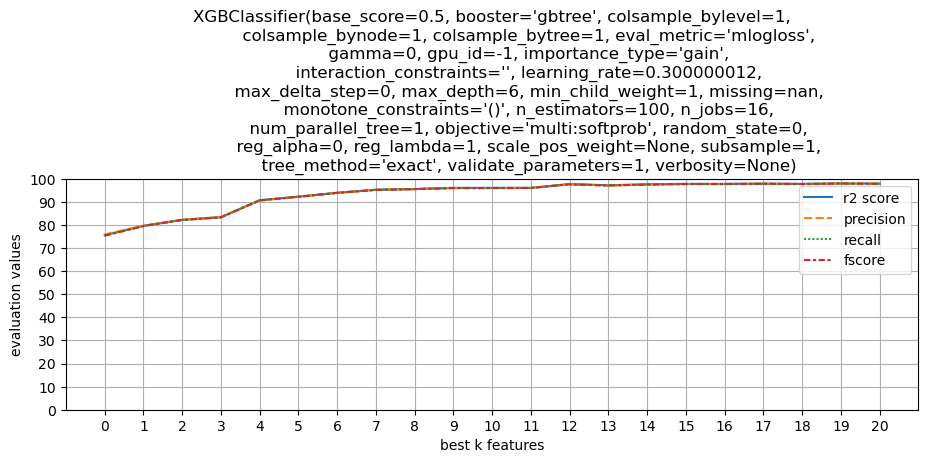

In [28]:

warnings.filterwarnings("ignore")

for model in [LogisticRegression(), RandomForestClassifier(), XGBClassifier(eval_metric='mlogloss')]:
    li_score = []
    li_precision = []
    li_recall = []
    li_fscore = []


    for i in tqdm(range(1, X.shape[1]+1)):
        
        X_train_new = select_best(X_train, y_train, i)
        X_val_new = X_val[X_train_new.columns]

#         model = find_best_model(X_train_new, y_train)

        model.fit(X_train_new, y_train)
        y_pred = model.predict(X_val_new)

        # evaluation
        avg = 'macro'
        a = accuracy_score(y_val, y_pred)
        p = precision_score(y_val, y_pred, average=avg)
        r = recall_score(y_val, y_pred, average=avg)
        f = f1_score(y_val, y_pred, average=avg)
        
        li_score.append(a*100)
        li_precision.append(p*100)
        li_recall.append(r*100)
        li_fscore.append(f*100)
    plot_results(model, li_score, li_precision, li_recall, li_fscore)

## 4. Model Selection & Validation

## <span style='color:red'>Necessary</span>

- Select Most Important Features
- Validating Multiple Algorithms and Select best One(s)

## <span style='color:Blue'>Additionals</span>

- Remote DB
- Website